### Importing libraries

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import sklearn

In [3]:
df = pd.read_csv('train.csv')
df = pd.DataFrame(df)
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### Checking for null values

In [4]:
df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

### Cleaning the text

In [5]:
import re
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text.lower()
df['cleaned_comment'] = df['comment_text'].apply(clean_text)
df.drop(columns=['comment_text', 'id'], inplace=True)
df.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned_comment
0,0,0,0,0,0,0,explanation\nwhy the edits made under my usern...
1,0,0,0,0,0,0,daww he matches this background colour im seem...
2,0,0,0,0,0,0,hey man im really not trying to edit war its j...
3,0,0,0,0,0,0,\nmore\ni cant make any real suggestions on im...
4,0,0,0,0,0,0,you sir are my hero any chance you remember wh...


### Checking for any imbalance 

In [6]:
df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum()

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

### Computing class weight for each label

In [7]:
from sklearn.utils import class_weight

label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
class_weights = {}

for col in label_cols:
    weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(df[col]),
        y=df[col]
    )
    class_weights[col] = dict(enumerate(weights))
class_weights

{'toxic': {0: np.float64(0.5530022110246262),
  1: np.float64(5.216784359879691)},
 'severe_toxic': {0: np.float64(0.5050482351749633),
  1: np.float64(50.02225705329153)},
 'obscene': {0: np.float64(0.5279542356506663),
  1: np.float64(9.443188543022844)},
 'threat': {0: np.float64(0.5015022659702186),
  1: np.float64(166.9152719665272)},
 'insult': {0: np.float64(0.5259634527403853),
  1: np.float64(10.128919639456646)},
 'identity_hate': {0: np.float64(0.5044415361076338),
  1: np.float64(56.78683274021353)}}

In [8]:
# Create a weight matrix: shape (6, 2) for 6 labels and 2 classes (0 and 1)
weight_matrix = np.array([[class_weights[label][0], class_weights[label][1]] for label in label_cols])
weight_tensor = tf.constant(weight_matrix, dtype=tf.float32)

In [9]:
def multilabel_weighted_loss(y_true, y_pred):
   
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Binary crossentropy: shape (batch_size, 6)
    bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)

    # Extract weights for class 0 and class 1
    w0 = weight_matrix[:, 0]  # shape: (6,)
    w1 = weight_matrix[:, 1]  # shape: (6,)

    # Broadcast weights across batch
    weights = y_true * w1 + (1 - y_true) * w0  # shape: (batch_size, 6)

    # Apply weights to loss
    weighted_loss = bce * weights

    return tf.reduce_mean(weighted_loss)

# LSTM Model

### Split into training, validation and test sets

In [10]:
from skmultilearn.model_selection import iterative_train_test_split

X = df['cleaned_comment']
y = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]  

X_np = np.array(X).reshape(-1, 1)  # reshape for compatibility
y_np = y.values

X_train, y_train, X_temp, y_temp = iterative_train_test_split(X_np, y_np, test_size=0.3)

X_val, y_val, X_test, y_test = iterative_train_test_split(X_temp, y_temp, test_size=0.5)

### Creating labels

In [11]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
labels = df[label_cols].values

### Building the model

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential([
    Embedding(input_dim=50000, output_dim=128, input_shape=(150,)),
    LSTM(64),
    Dropout(0.5),
    Dense(6, activation='sigmoid')
])

c:\Users\krith\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 150, 128)       │     6,400,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,449,798 (24.60 MB)

 Trainable params: 6,449,798 (24.60 MB)

 Non-trainable params: 0 (0.00 B)

### Compile the model

In [14]:
model.compile(
    loss=multilabel_weighted_loss,
    optimizer='adam',
    metrics=['accuracy']
)

### Turning dataframes to 2D arrays

In [15]:
y_train = y_train
y_val = y_val

### Cleaning

In [16]:
X_train = [clean_text(x[0]) for x in X_train]
X_val = [clean_text(x[0]) for x in X_val]

In [17]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

X_train = [clean_text(str(x)) for x in X_train]
X_val = [clean_text(str(x)) for x in X_val]
X_test = [clean_text(str(x)) for x in X_test]

### Tokenizing and padding

In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=15000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_len = 200
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

In [19]:
import numpy as np
print(np.max(X_test_pad))  # Should be < 15000

14999


In [20]:
y_train = np.array(y_train).astype('float32')
y_val = np.array(y_val).astype('float32')

### Computing class weight

In [21]:
from sklearn.utils import class_weight

label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
class_weights = {}

for col in label_cols:
    weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(df[col]),
        y=df[col]
    )
    class_weights[col] = dict(enumerate(weights))

# Convert to matrix
weight_matrix = np.array([[class_weights[label][0], class_weights[label][1]] for label in label_cols])

In [22]:
weight_matrix_tf = tf.constant(weight_matrix, dtype=tf.float32)

def multilabel_weighted_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)

    w0 = weight_matrix_tf[:, 0]
    w1 = weight_matrix_tf[:, 1]

    weights = y_true * w1 + (1 - y_true) * w0
    weighted_loss = bce * weights

    return tf.reduce_mean(weighted_loss)

In [23]:
from keras.regularizers import l2

model = Sequential([
    Embedding(input_dim=15000, output_dim=64, input_length=200),
    LSTM(64),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(6, activation='sigmoid')
])

c:\Users\krith\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [24]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.fit(X_train_pad[:100], y_train[:100], epochs=1)

In [25]:
print("X_train_pad:", type(X_train_pad), np.shape(X_train_pad))
print("y_train:", type(y_train), np.shape(y_train))
print("X_val_pad:", type(X_val_pad), np.shape(X_val_pad))
print("y_val:", type(y_val), np.shape(y_val))

X_train_pad: <class 'numpy.ndarray'> (111699, 200)
y_train: <class 'numpy.ndarray'> (111699, 6)
X_val_pad: <class 'numpy.ndarray'> (23936, 200)
y_val: <class 'numpy.ndarray'> (23936, 6)


In [26]:
print("Train samples:", len(X_train_pad), len(y_train))
print("Validation samples:", len(X_val_pad), len(y_val))
print("Test samples:", len(X_test_pad), len(y_test))

Train samples: 111699 111699
Validation samples: 23936 23936
Test samples: 23936 23936


In [27]:
X_train_pad = np.array(X_train_pad)
y_train = np.array(y_train).astype(np.float32)
X_val_pad = np.array(X_val_pad)
y_val = np.array(y_val).astype(np.float32)
X_test_pad = np.array(X_test_pad)
y_test = np.array(y_test).astype(np.float32)

In [28]:
print(np.any(np.isnan(X_train_pad)), np.any(np.isnan(y_train)))
print(np.any(np.isinf(X_train_pad)), np.any(np.isinf(y_train)))

False False
False False


In [29]:
# model.fit(X_train_pad[:100], y_train[:100], epochs=1)

### Model training

In [30]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=50,
    callbacks=[early_stop]
)

Epoch 1/50
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 128s 36ms/step - accuracy: 0.9132 - loss: 0.1545 - val_accuracy: 0.9946 - val_loss: 0.1312
Epoch 2/50
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 127s 36ms/step - accuracy: 0.9940 - loss: 0.0726 - val_accuracy: 0.9946 - val_loss: 0.0558
Epoch 3/50
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 167s 48ms/step - accuracy: 0.9940 - loss: 0.0538 - val_accuracy: 0.9946 - val_loss: 0.0531
Epoch 4/50
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 174s 50ms/step - accuracy: 0.9940 - loss: 0.0482 - val_accuracy: 0.9946 - val_loss: 0.0520
Epoch 5/50
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 169s 48ms/step - accuracy: 0.9940 - loss: 0.0445 - val_accuracy: 0.9946 - val_loss: 0.0563
Epoch 6/50
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 177s 51ms/step - accuracy: 0.9938 - loss: 0.0413 - val_accuracy: 0.9946 - val_loss: 0.0555


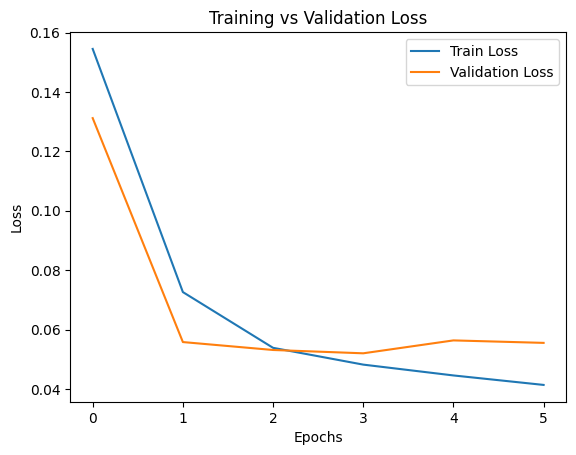

In [31]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

### Evaluate the model

In [32]:
loss, acc = model.evaluate(X_test_pad, y_test, verbose=2)
print("Test Accuracy:", acc)

748/748 - 14s - 19ms/step - accuracy: 0.9944 - loss: 0.0568
Test Accuracy: 0.994401752948761


### Making the predictions with validation dataset

In [33]:
y_pred_proba = model.predict(X_val_pad)

748/748 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step


### Threshold tuning with Precision, Recall and F1-Score

In [34]:
import numpy as np
from sklearn.metrics import f1_score

best_thresholds = []

for i in range(y_val.shape[1]):
    thresholds = np.linspace(0.1, 0.9, 9)
    f1_scores = []

    for t in thresholds:
        y_pred_bin = (y_pred_proba[:, i] > t).astype(int)
        f1 = f1_score(y_val[:, i], y_pred_bin, zero_division=0)
        f1_scores.append(f1)

    best_t = thresholds[np.argmax(f1_scores)]
    best_thresholds.append(best_t)

best_thresholds

[np.float64(0.5),
 np.float64(0.30000000000000004),
 np.float64(0.4),
 np.float64(0.1),
 np.float64(0.4),
 np.float64(0.1)]

In [35]:
y_pred_opt = np.zeros_like(y_pred_proba)

for i, t in enumerate(best_thresholds):
    y_pred_opt[:, i] = (y_pred_proba[:, i] > t).astype(int)

### Making predictions with test dataset by applying the tuned threshold

In [36]:
y_test_probs = model.predict(X_test_pad)
y_test_pred = (y_test_probs > best_thresholds).astype(int)

748/748 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step


### Classification report

In [37]:
import numpy as np
from sklearn.metrics import classification_report

# Convert list to NumPy array
thresholds = np.array(best_thresholds)  # shape: (6,)

# Apply thresholds to predicted probabilities
y_test_pred = (y_test_probs > thresholds).astype(int)

# Evaluate performance
print(np.sum(y_test_pred, axis=0))  # Number of predicted positives per class
print(classification_report(y_test, y_test_pred, target_names=[
    'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'
]))

[2157  418 1363    0 1285  824]
               precision    recall  f1-score   support

        toxic       0.80      0.75      0.77      2294
 severe_toxic       0.37      0.64      0.47       239
      obscene       0.75      0.81      0.78      1268
       threat       0.00      0.00      0.00        72
       insult       0.67      0.73      0.70      1182
identity_hate       0.12      0.45      0.19       220

    micro avg       0.64      0.73      0.68      5275
    macro avg       0.45      0.56      0.48      5275
 weighted avg       0.70      0.73      0.71      5275
  samples avg       0.06      0.07      0.06      5275



c:\Users\krith\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\krith\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\krith\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

### Visualization

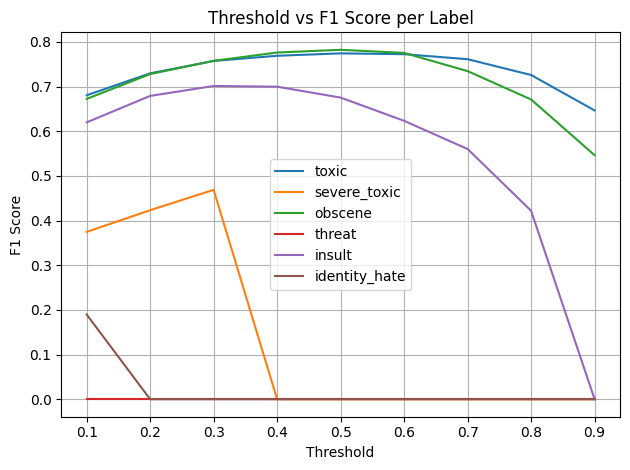

In [38]:
import matplotlib.pyplot as plt

for i, label in enumerate(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']):
    thresholds = np.linspace(0.1, 0.9, 9)
    f1s = [f1_score(y_test[:, i], (y_test_probs[:, i] > t).astype(int), zero_division=0) for t in thresholds]
    plt.plot(thresholds, f1s, label=label)

plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("Threshold vs F1 Score per Label")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Confusion matrix

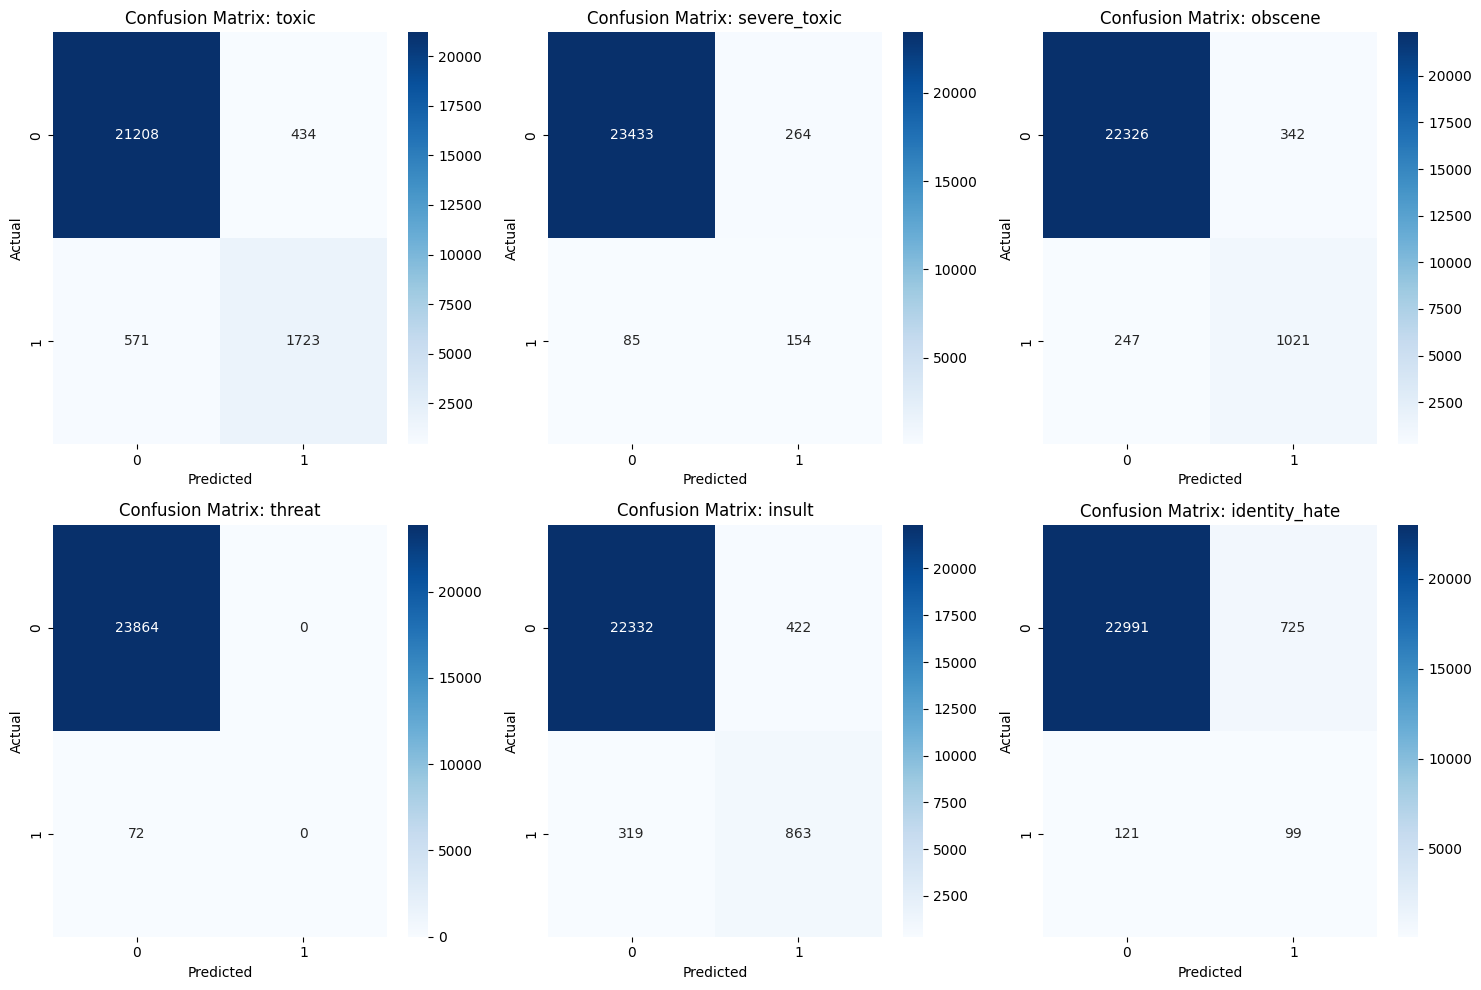

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

target_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, label in enumerate(target_names):
    cm = confusion_matrix(y_test[:, i], y_test_pred[:, i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix: {label}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [40]:
import numpy as np
import pickle
from tensorflow.keras.models import load_model

# Save model
model.save("toxicity_model/lstm_model.keras")

# Save tokenizer
with open("toxicity_model/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Save thresholds
np.save("toxicity_model/best_thresholds.npy", np.array(best_thresholds))

# CNN

### Tokenization

In [41]:
cnn_X_train_pad = X_train_pad.copy()
cnn_X_val_pad = X_val_pad.copy()
cnn_X_test_pad = X_test_pad.copy()

cnn_y_train = y_train.copy()
cnn_y_val = y_val.copy()
cnn_y_test = y_test.copy()

### Computing the class weights

In [42]:
from sklearn.utils import class_weight
import numpy as np

label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
cnn_class_weights = {}

for col in label_cols:
    weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(df[col]),
        y=df[col]
    )
    cnn_class_weights[col] = dict(enumerate(weights))

In [43]:
cnn_weight_matrix = np.array([[cnn_class_weights[label][i] for i in range(2)] for label in label_cols])
cnn_weight_tensor = tf.constant(cnn_weight_matrix, dtype=tf.float32)

In [44]:
import tensorflow as tf
from tensorflow.keras import backend as K

def cnn_weighted_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    base_loss = K.binary_crossentropy(y_true, y_pred)

    w0 = cnn_weight_tensor[:, 0]
    w1 = cnn_weight_tensor[:, 1]

    weights = y_true * w1 + (1 - y_true) * w0
    weighted_loss = base_loss * weights

    return tf.reduce_mean(weighted_loss)

### Model defining

In [45]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from keras.regularizers import l2

cnn_model = Sequential([
    Embedding(input_dim=15000, output_dim=128, input_length=200),
    Conv1D(filters=64, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(6, activation='sigmoid')
])

c:\Users\krith\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


### Compiling

In [46]:
cnn_model.compile(optimizer='adam', loss=cnn_weighted_loss, metrics=['accuracy'])

### Training

In [47]:
from tensorflow.keras.callbacks import EarlyStopping

cnn_early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

cnn_history = cnn_model.fit(
    cnn_X_train_pad, cnn_y_train,
    validation_data=(cnn_X_val_pad, cnn_y_val),
    epochs=50,
    batch_size=32,
    callbacks=[cnn_early_stop]
)

Epoch 1/50
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 56s 16ms/step - accuracy: 0.7234 - loss: 0.3088 - val_accuracy: 0.9946 - val_loss: 0.2047
Epoch 2/50
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 51s 15ms/step - accuracy: 0.9801 - loss: 0.1925 - val_accuracy: 0.9859 - val_loss: 0.1901
Epoch 3/50
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 57s 16ms/step - accuracy: 0.9810 - loss: 0.1564 - val_accuracy: 0.9753 - val_loss: 0.1848
Epoch 4/50
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 111s 32ms/step - accuracy: 0.9878 - loss: 0.1346 - val_accuracy: 0.9860 - val_loss: 0.1798
Epoch 5/50
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 48s 14ms/step - accuracy: 0.9879 - loss: 0.1241 - val_accuracy: 0.9898 - val_loss: 0.2474
Epoch 6/50
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 49s 14ms/step - accuracy: 0.9862 - loss: 0.1171 - val_accuracy: 0.9890 - val_loss: 0.2174
Epoch 7/50
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 50s 14ms/step - accuracy: 0.9865 - loss: 0.1125 - val_accuracy: 0.9910 - val_loss: 0.2916


### Predict and apply default thresholds

In [48]:
cnn_y_val_probs = cnn_model.predict(cnn_X_val_pad)

cnn_y_val_pred_default = (cnn_y_val_probs > 0.5).astype(int)

748/748 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


### Evaluate the model with default thresholds

In [49]:
from sklearn.metrics import accuracy_score

cnn_exact_match_acc = accuracy_score(cnn_y_val, cnn_y_val_pred_default)
print("Exact Match Accuracy:", cnn_exact_match_acc)

Exact Match Accuracy: 0.8343081550802139


### Applying the tuned thresholds

In [50]:
cnn_y_val_probs = cnn_model.predict(cnn_X_val_pad)

cnn_best_thresholds = []
for i in range(cnn_y_val.shape[1]):
    thresholds = np.linspace(0.1, 0.9, 9)
    f1s = [f1_score(cnn_y_val[:, i], (cnn_y_val_probs[:, i] > t).astype(int), zero_division=0) for t in thresholds]
    cnn_best_thresholds.append(thresholds[np.argmax(f1s)])
cnn_best_thresholds

748/748 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


[np.float64(0.8),
 np.float64(0.9),
 np.float64(0.9),
 np.float64(0.9),
 np.float64(0.9),
 np.float64(0.9)]

In [51]:
cnn_y_val_pred = np.zeros_like(cnn_y_val_probs)
for i, t in enumerate(cnn_best_thresholds):
    cnn_y_val_pred[:, i] = (cnn_y_val_probs[:, i] > t).astype(int)

### Classification report

In [52]:
from sklearn.metrics import classification_report

target_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

print(classification_report(cnn_y_val, cnn_y_val_pred, target_names=target_names, zero_division=0))

               precision    recall  f1-score   support

        toxic       0.73      0.80      0.76      2294
 severe_toxic       0.24      0.85      0.38       239
      obscene       0.76      0.81      0.78      1267
       threat       0.14      0.93      0.25        71
       insult       0.64      0.78      0.70      1181
identity_hate       0.18      0.69      0.29       206

    micro avg       0.57      0.80      0.66      5258
    macro avg       0.45      0.81      0.53      5258
 weighted avg       0.66      0.80      0.71      5258
  samples avg       0.06      0.07      0.06      5258



### Prediction on test dataset

In [53]:
cnn_y_test_probs = cnn_model.predict(cnn_X_test_pad)
cnn_y_test_pred = np.zeros_like(cnn_y_test_probs)

for i, t in enumerate(cnn_best_thresholds):
    cnn_y_test_pred[:, i] = (cnn_y_test_probs[:, i] > t).astype(int)

748/748 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


### Confusion matrix

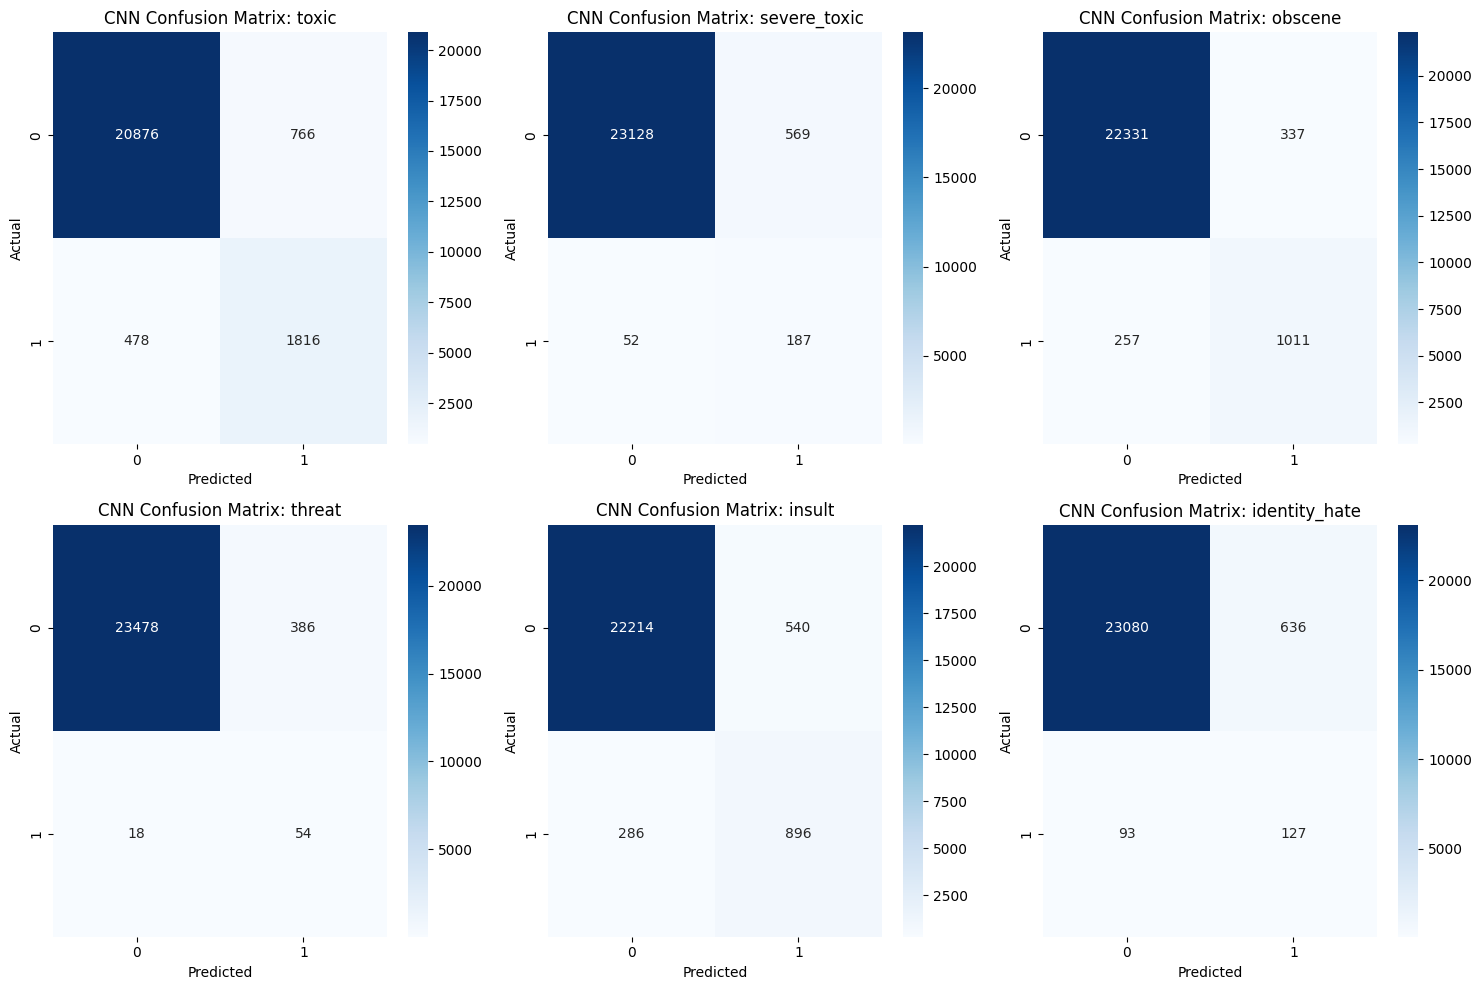

In [54]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, label in enumerate(target_names):
    cm = confusion_matrix(cnn_y_test[:, i], cnn_y_test_pred[:, i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'CNN Confusion Matrix: {label}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()